# Predykcja Ryzyka Udaru Mózgu 🧠

Ten projekt wykorzystuje metody klasyfikacji uczenia maszynowego do przewidywania, czy pacjent jest zagrożony udarem, w oparciu o cechy demograficzne, zdrowotne i styl życia. Zbiór danych zawiera ponad 5000 obserwacji ze zmiennymi takimi jak wiek, płeć, nadciśnienie, średni poziom glukozy, wskaźnik masy ciała (BMI) i status palenia.

## 1. Konfiguracja Środowiska

Najpierw zaimportujemy wszystkie niezbędne biblioteki i zdefiniujemy podstawowe parametry konfiguracyjne.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, f1_score, precision_score, recall_score
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC

from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline dla imblearn
from imblearn.over_sampling import SMOTE

# Konfiguracja
DATASET_PATH = 'data/healthcare-dataset-stroke-data.csv'
MODEL_SAVE_DIR = 'models/'
RESULTS_DIR = 'results/'
RANDOM_STATE = 42
TEST_SIZE = 0.2
TARGET_COLUMN = 'stroke'
LOG_REG_MODEL_NAME = "logistic_regression_model.joblib"
RF_MODEL_NAME = "random_forest_model.joblib"
SVM_MODEL_NAME = "svm_model.joblib"
VOTING_MODEL_NAME = "voting_classifier_model.joblib"

# Tworzenie katalogów, jeśli nie istnieją
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Ustawienia wizualizacji
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Środowisko skonfigurowane.")

Środowisko skonfigurowane.


## 2. Funkcje Pomocnicze

Definiujemy funkcje, które będą używane w całym procesie - do wczytywania danych, wstępnej analizy danych, preprocessingu, trenowania i ewaluacji.

In [14]:

def load_data(path: str = DATASET_PATH) -> pd.DataFrame:
    """Wczytuje zbiór danych i usuwa 'id'."""
    try:
        df = pd.read_csv(path)
        print(f"Wczytano dane z: {path}")
        if 'id' in df.columns:
            df.drop('id', axis=1, inplace=True)
            print("Usunięto kolumnę 'id'.")
        return df
    except FileNotFoundError:
        print(f"Błąd: Plik '{path}' nie został znaleziony.")
        return pd.DataFrame()

def display_basic_info(df: pd.DataFrame):
    """Wyświetla podstawowe informacje o DataFrame."""
    print("\n--- Podstawowe informacje o danych ---")
    print("Pierwsze 5 wierszy:")
    print(df.head())
    print(f"\nWymiary zbioru danych: {df.shape}")
    print("\nInformacje o typach danych i brakach:")
    df.info()
    print("\nStatystyki opisowe dla cech numerycznych:")
    print(df.describe())

def plot_numerical_distributions(df: pd.DataFrame, numerical_features: list, save_plots: bool = False):
    """Rysuje histogramy i boxploty dla cech numerycznych."""
    print("\n--- Rozkłady cech numerycznych ---")
    binary_columns = [col for col in numerical_features if df[col].nunique() == 2]
    if binary_columns:
        for col in binary_columns:
            plt.figure(figsize=(6, 6))
            value_counts = df[col].value_counts()
            plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
            plt.title(f'Rozkład dla {col} (cecha binarna)')
            if save_plots: plt.savefig(os.path.join(RESULTS_DIR, f'binary_{col}.png'))
            plt.show()
    for col in numerical_features:
        if col not in binary_columns:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            sns.histplot(df[col], kde=False)
            plt.title(f'Histogram dla {col}')
            plt.subplot(1, 2, 2)
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot dla {col}')
            plt.tight_layout()
            if save_plots: plt.savefig(os.path.join(RESULTS_DIR, f'dist_{col}.png'))
            plt.show()

def plot_categorical_distributions(df: pd.DataFrame, categorical_features: list, save_plots: bool = False):
    """Rysuje wykresy słupkowe dla cech kategorycznych."""
    print("\n--- Rozkłady cech kategorycznych ---")
    for col in categorical_features:
        plt.figure(figsize=(10, 6))
        sns.countplot(y=df[col], order = df[col].value_counts().index)
        plt.title(f'Częstość dla {col}')
        plt.tight_layout()
        if save_plots: plt.savefig(os.path.join(RESULTS_DIR, f'count_{col}.png'))
        plt.show()

def plot_target_distribution(df: pd.DataFrame, save_plots: bool = False):
    """Rysuje rozkład zmiennej celu."""
    print(f"\n--- Rozkład zmiennej celu ({TARGET_COLUMN}) ---")
    plt.figure(figsize=(6, 4))
    plt.pie(df[TARGET_COLUMN].value_counts(),
            labels=df[TARGET_COLUMN].unique(),
            autopct='%1.1f%%',
            startangle=140)
    plt.title(f'Rozkład zmiennej celu ({TARGET_COLUMN})')
    if save_plots: plt.savefig(os.path.join(RESULTS_DIR, f'target_dist_{TARGET_COLUMN}.png'))
    plt.show()
    print(df[TARGET_COLUMN].value_counts(normalize=True))

def plot_correlation_matrix(df: pd.DataFrame, save_plots: bool = False):
    """Rysuje macierz korelacji."""
    print("\n--- Macierz korelacji ---")
    temp_df = df.copy()
    for col in temp_df.columns:
        if temp_df[col].dtype == 'object':
            temp_df[col] = temp_df[col].astype('category').cat.codes
    correlation_matrix = temp_df.corr()
    plt.figure(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Macierz Korelacji')
    plt.tight_layout()
    if save_plots: plt.savefig(os.path.join(RESULTS_DIR, 'correlation_matrix.png'))
    plt.show()

def handle_gender_other(df: pd.DataFrame) -> pd.DataFrame:
    """Usuwa wiersze z 'gender' == 'Other'."""
    if 'gender' in df.columns and 'Other' in df['gender'].unique():
        df = df[df['gender'] != 'Other'].copy()
        print("Usunięto wiersze z 'gender' == 'Other'.")
    return df

def get_feature_types(df: pd.DataFrame) -> tuple[list, list]:
    """Identyfikuje cechy numeryczne i kategoryczne."""
    numerical_features = df.select_dtypes(include=np.number).columns.tolist()
    categorical_features = df.select_dtypes(include='object').columns.tolist()
    if TARGET_COLUMN in numerical_features:
        numerical_features.remove(TARGET_COLUMN)
    if TARGET_COLUMN in categorical_features:
        categorical_features.remove(TARGET_COLUMN)
    return numerical_features, categorical_features

def create_preprocessor(numerical_features: list, categorical_features: list) -> ColumnTransformer:
    """Tworzy preprocesor ColumnTransformer."""
    numerical_pipeline_full = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline_full, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )
    return preprocessor

def split_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Dzieli dane na zbiory treningowe i testowe."""
    X = df.drop(TARGET_COLUMN, axis=1)
    y = df[TARGET_COLUMN]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    return X_train, X_test, y_train, y_test

def define_base_models(class_weight='balanced') -> dict:
    """Definiuje podstawowe modele klasyfikacyjne."""
    log_reg = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, class_weight=class_weight, max_iter=1000)
    random_forest = RandomForestClassifier(random_state=RANDOM_STATE, class_weight=class_weight)
    svm_clf = SVC(probability=True, random_state=RANDOM_STATE, class_weight=class_weight)
    return {
        "Logistic Regression": log_reg,
        "Random Forest": random_forest,
        "Support Vector Machine": svm_clf
    }

def create_full_model_pipeline(preprocessor, model_instance, use_smote: bool = True):
    """Tworzy pełny pipeline dla modelu."""
    steps = [('preprocessor', preprocessor)]
    if use_smote:
        steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
    steps.append(('classifier', model_instance))
    return ImbPipeline(steps=steps)

def train_model(pipeline, X_train, y_train):
    """Trenuje podany pipeline modelu."""
    pipeline.fit(X_train, y_train)
    return pipeline

def define_voting_classifier_pipeline(preprocessor, log_reg_model, rf_model, svm_model, use_smote: bool = True):
    """Definiuje VotingClassifier."""
    voting_clf_instance = VotingClassifier(
        estimators=[('lr', log_reg_model), ('rf', rf_model), ('svc', svm_model)],
        voting='soft'
    )
    steps = [('preprocessor', preprocessor)]
    if use_smote:
        steps.append(('smote', SMOTE(random_state=RANDOM_STATE)))
    steps.append(('voting_classifier', voting_clf_instance))
    return ImbPipeline(steps=steps)

def get_predictions(model, X_data) -> tuple[pd.Series, pd.Series]:
    """Generuje predykcje."""
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)[:, 1]
    return y_pred, y_proba

def print_evaluation_summary(model_name: str, y_true, y_pred, y_proba):
    """Drukuje podsumowanie ewaluacji."""
    print(f"\n--- Ocena dla modelu: {model_name} ---")
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'AUC-ROC': roc_auc_score(y_true, y_proba)
    }
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    print("\nMacierz pomyłek:")
    print(cm)
    print("\nRaport klasyfikacyjny:")
    print(classification_report(y_true, y_pred, target_names=['Brak udaru (0)', 'Udar (1)']))
    return metrics, cm

def plot_confusion_matrix_heatmap(cm, model_name: str, save_plot: bool = False):
    """Rysuje macierz pomyłek jako heatmap."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Brak udaru (0)', 'Udar (1)'], 
                yticklabels=['Brak udaru (0)', 'Udar (1)'])
    plt.title(f'Macierz pomyłek dla {model_name}')
    plt.xlabel('Przewidziane'); plt.ylabel('Rzeczywiste')
    plt.tight_layout()
    if save_plot: plt.savefig(os.path.join(RESULTS_DIR, f'cm_{model_name.replace(" ", "_")}.png'))
    plt.show()

def _get_feature_names(prep):
    """Zwraca listę nazw cech w kolejności zgodnej z wektorem X po przetworzeniu."""
    num_feats = prep.transformers_[0][2]
    cat_feats = prep.transformers_[1][2]
    ohe = prep.transformers_[1][1]          # OneHotEncoder
    ohe_feats = ohe.get_feature_names_out(cat_feats)
    return np.concatenate([num_feats, ohe_feats])

def extract_feature_weights(pipeline, X_val=None, y_val=None, n_repeats=10):
    """
    Zwraca DataFrame z wagami/ważnością cech.
    • Modele liniowe -> coef_
    • Modele drzewiaste -> feature_importances_
    • Inne -> permutation importance (wymaga X_val, y_val)
    """
    clf  = pipeline.named_steps["classifier"]
    prep = pipeline.named_steps["preprocessor"]
    feat_names = _get_feature_names(prep)

    # 1) Liniowe (LogReg, LinearSVC itp.)
    if hasattr(clf, "coef_"):
        coefs = clf.coef_.flatten()
        return (pd.DataFrame({"cecha": feat_names,
                              "waga":  coefs})
                .sort_values("waga", ascending=False))

    # 2) Drzewa/las/boosting itp.
    elif hasattr(clf, "feature_importances_"):
        imps = clf.feature_importances_
        return (pd.DataFrame({"cecha": feat_names,
                              "ważność":  imps})
                .sort_values("ważność", ascending=False))

    # 3) Inne-nieregularne – fallback na permutation importance
    elif X_val is not None and y_val is not None:
        perm = permutation_importance(pipeline, X_val, y_val,
                                      n_repeats=n_repeats, random_state=42, n_jobs=-1)
        return (pd.DataFrame({"cecha": feat_names,
                              "ważność_perm": perm.importances_mean})
                .sort_values("ważność_perm", ascending=False))

    else:
        raise NotImplementedError("Brak bezpośrednich wag i nie podano danych walidacyjnych.")

def report_model(model_name, pipeline, X_val=None, y_val=None):
    # Wagi / ważności
    try:
        weights_df = extract_feature_weights(pipeline, X_val, y_val)
        print(f"Ważność cech dla modelu: {model_name}")
        for _ , row in weights_df.iterrows():
            print(f"{row['cecha']}: {row.get('waga', row.get('ważność', row.get('ważność_perm'))):.4f}")
    except Exception as e:
        print(f"\n{e}\n(Wagi pominięte).")

print("Funkcje pomocnicze zdefiniowane.")

Funkcje pomocnicze zdefiniowane.


## 3. Wczytanie Danych

Wczytujemy dane z pliku CSV.

In [15]:
raw_df = load_data()

Wczytano dane z: data/healthcare-dataset-stroke-data.csv
Usunięto kolumnę 'id'.


## 4. Eksploracyjna Analiza Danych

Rozkłady, histogramy box-ploty zmiennych numerycznych i kategorycznych.


--- Podstawowe informacje o danych ---
Pierwsze 5 wierszy:
   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1  

Wymiary zbioru danych: (5110, 11)

Informacje o typach danych i brak

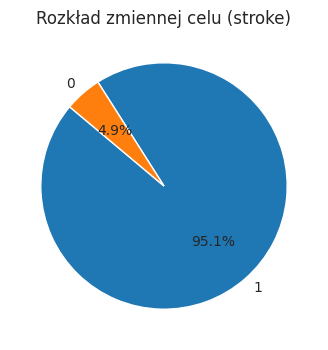

stroke
0    0.951272
1    0.048728
Name: proportion, dtype: float64

--- Rozkłady cech numerycznych ---


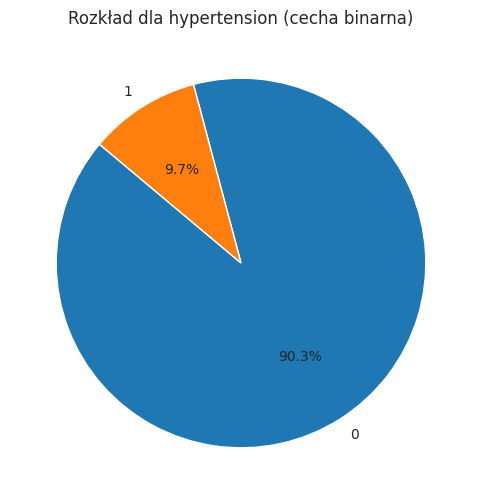

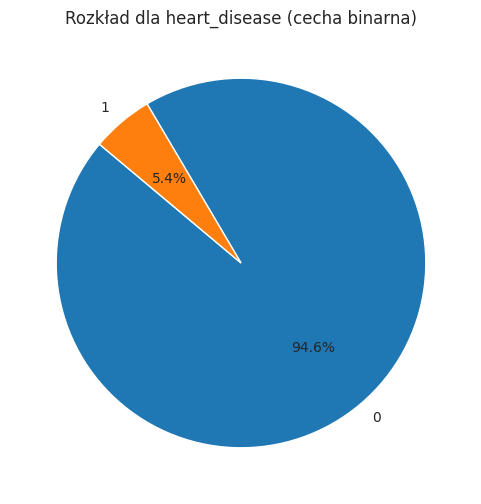

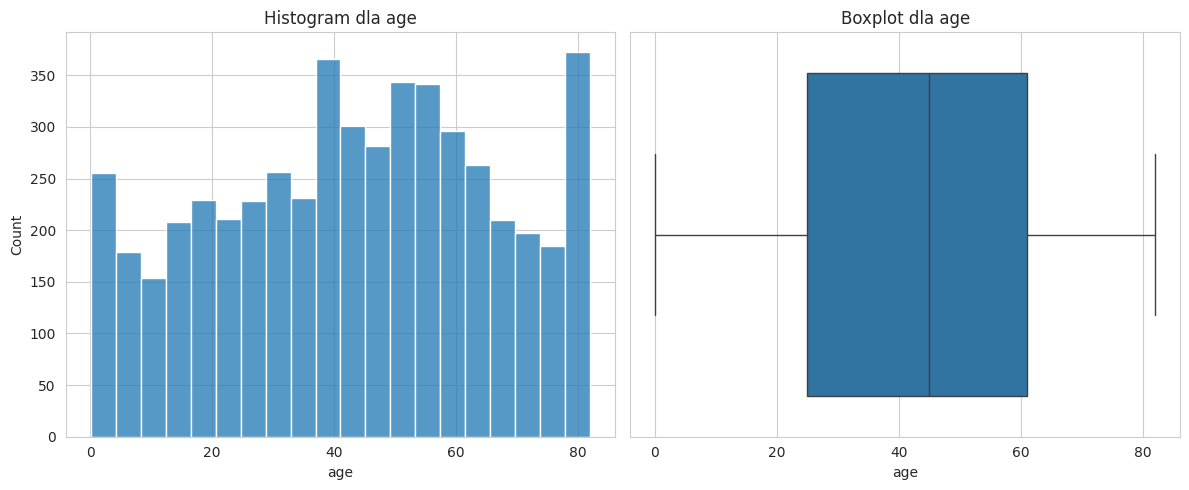

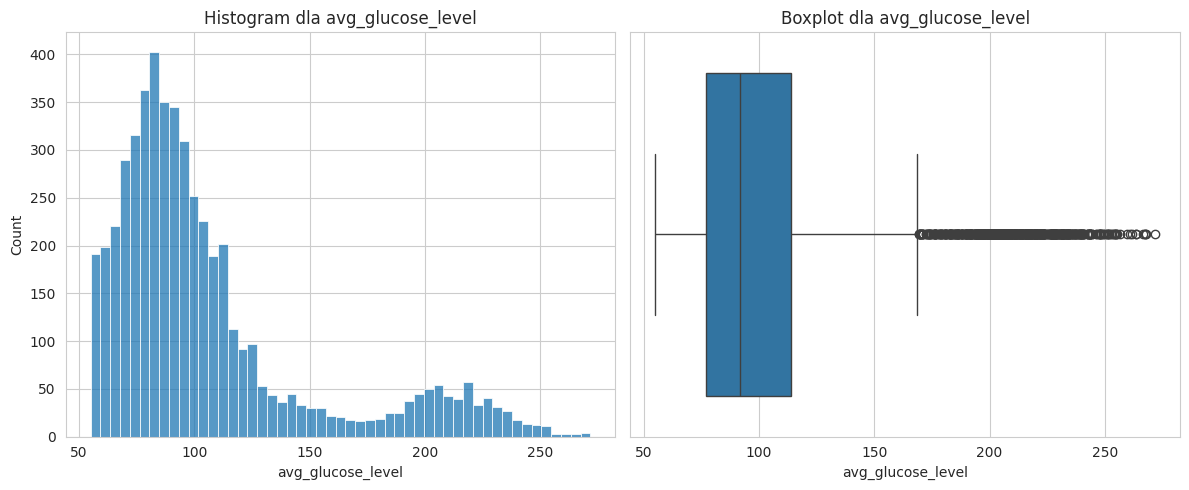

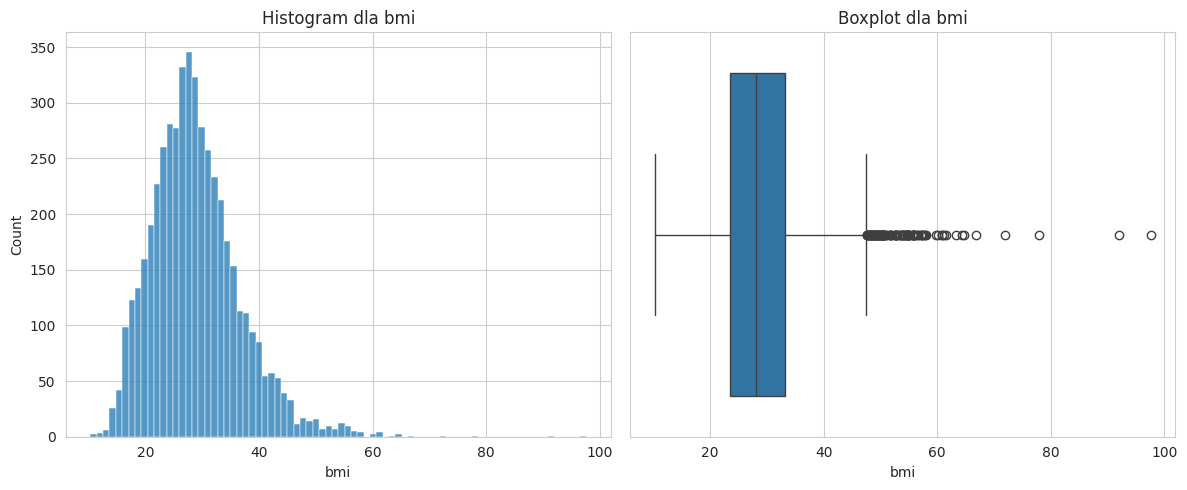


--- Rozkłady cech kategorycznych ---


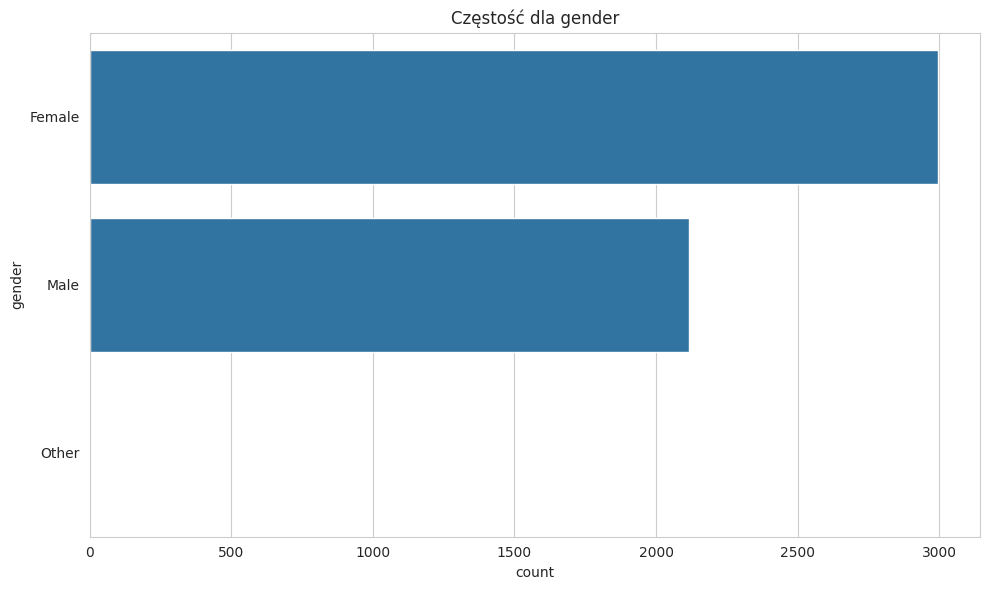

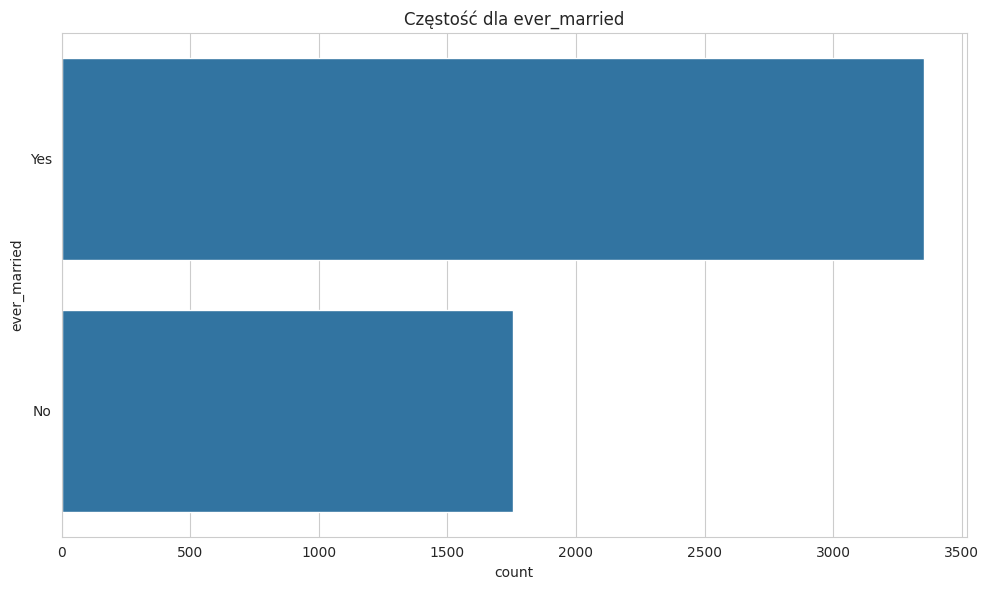

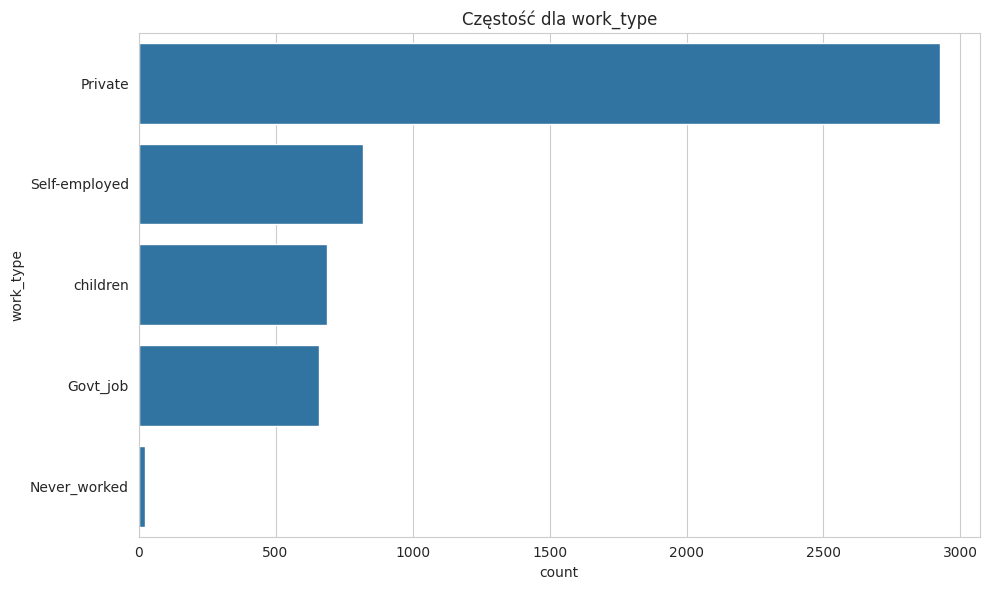

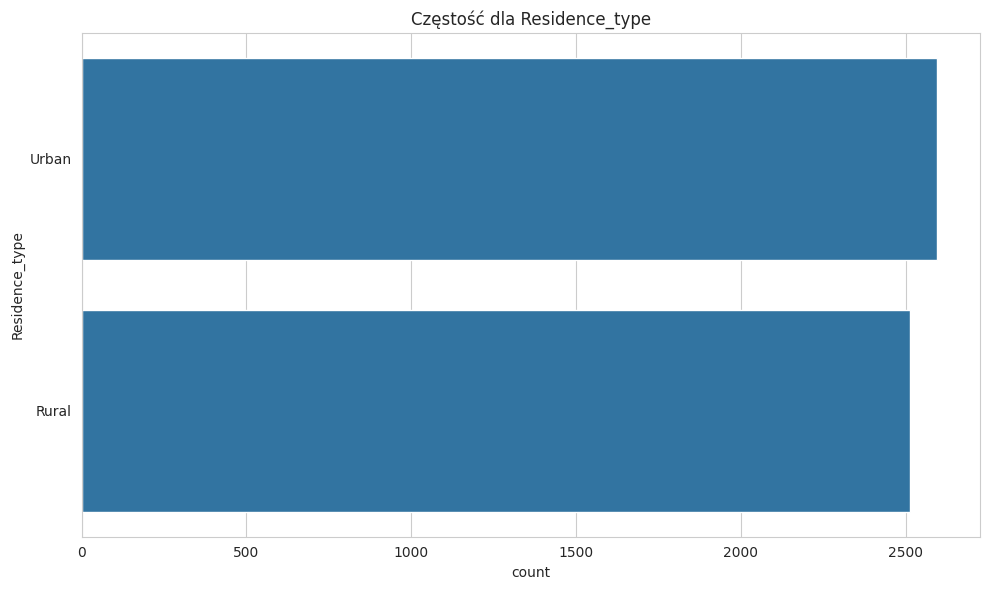

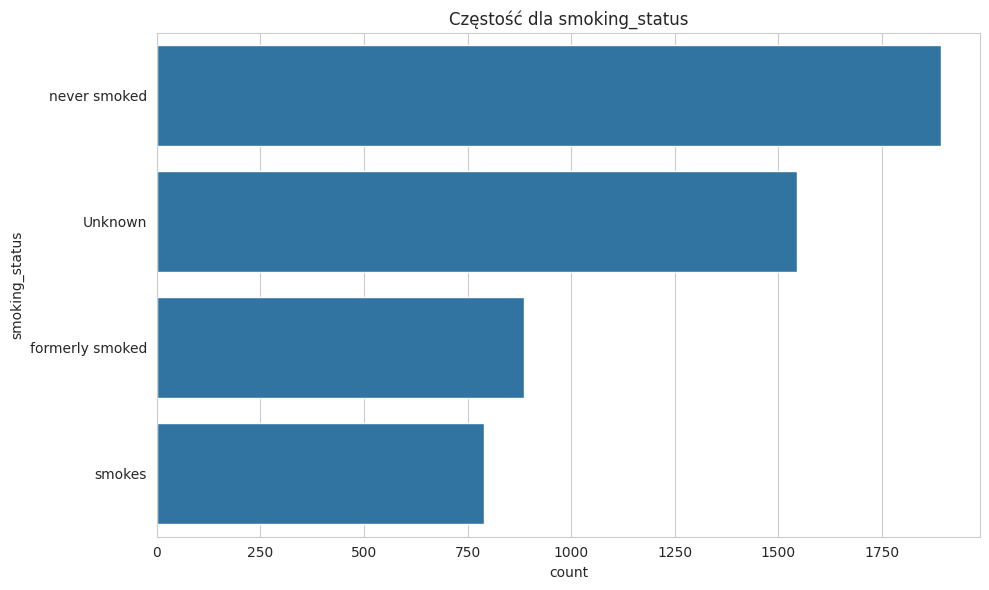


--- Macierz korelacji ---


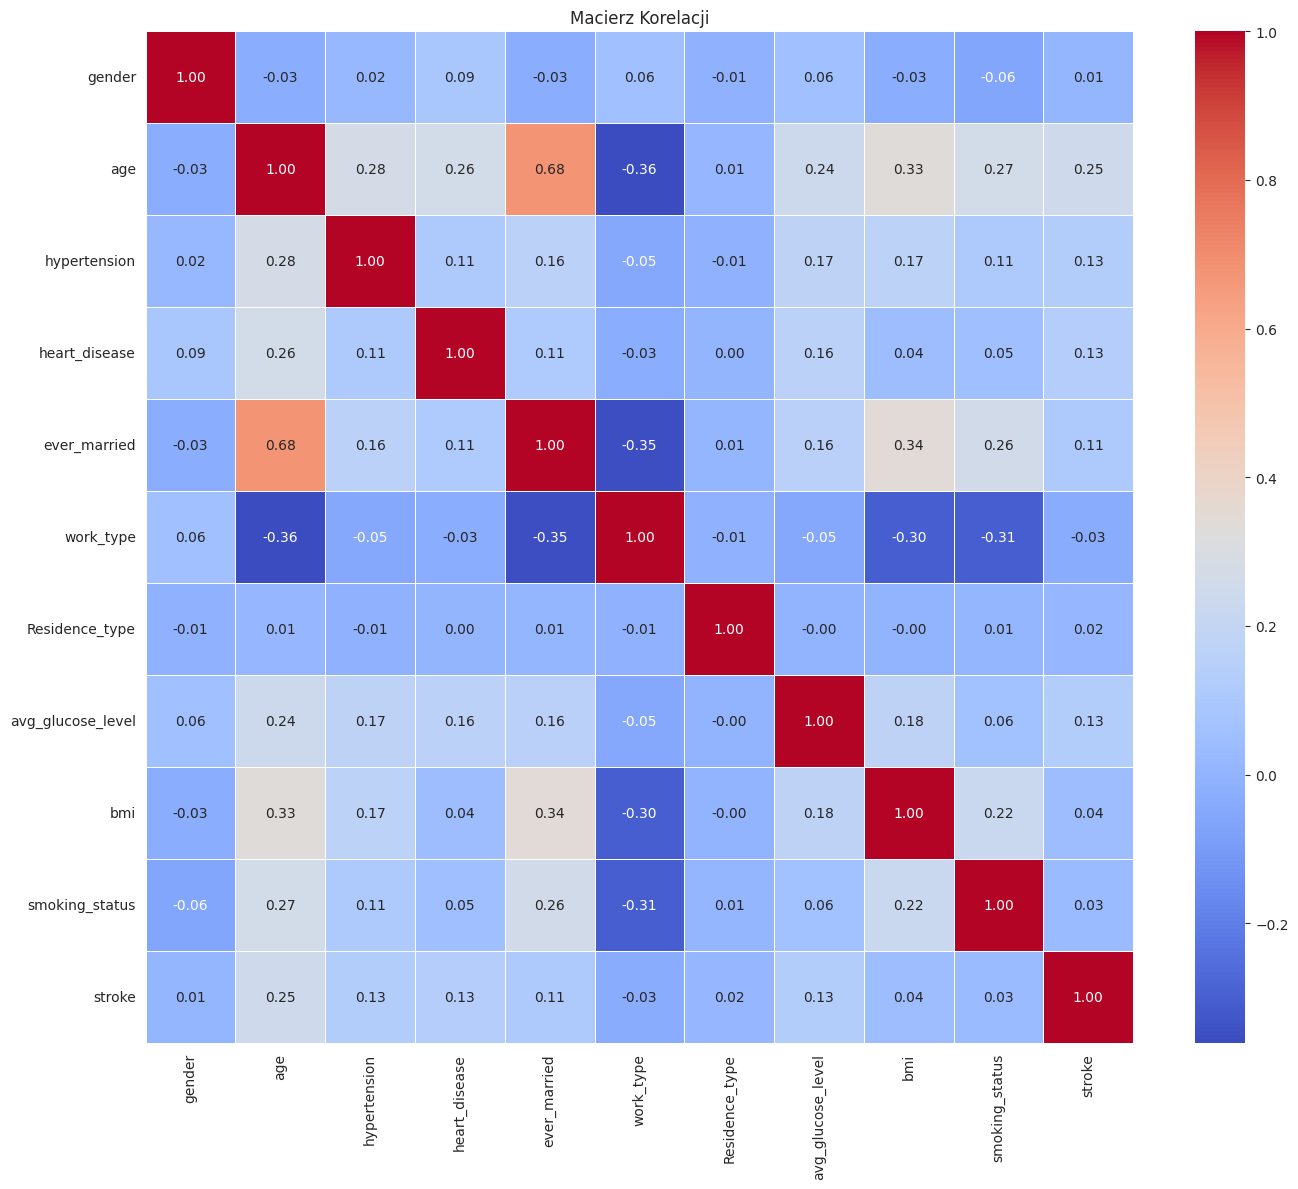

In [16]:
if not raw_df.empty:
    display_basic_info(raw_df.copy())
    
    num_feats, cat_feats = get_feature_types(raw_df.drop(TARGET_COLUMN, axis=1))
    
    plot_target_distribution(raw_df.copy(), save_plots=True)
    plot_numerical_distributions(raw_df.copy(), num_feats, save_plots=True)
    plot_categorical_distributions(raw_df.copy(), cat_feats, save_plots=True)
    plot_correlation_matrix(raw_df.copy(), save_plots=True)
else:
    print("DataFrame jest pusty, pomijanie EDA.")

## 5. Przetwarzanie Wstępne Danych (Preprocessing)

Przygotowujemy dane do modelowania: usuwamy nietypowe wartości, dzielimy na zbiory i tworzymy preprocesor.

In [17]:
if not raw_df.empty:
    print("\n--- Rozpoczynanie Przetwarzania Wstępnego ---")
    processed_df = handle_gender_other(raw_df)
    X_train_df, X_test_df, y_train_series, y_test_series = split_data(processed_df)
    
    numerical_features, categorical_features = get_feature_types(X_train_df)
    preprocessor_obj = create_preprocessor(numerical_features, categorical_features)
    print("Zakończono definiowanie preprocesora.")
    
    print("\nPróbka danych treningowych (X_train_df):")
    print(X_train_df.head())
else:
    print("DataFrame jest pusty, pomijanie Preprocessingu.")


--- Rozpoczynanie Przetwarzania Wstępnego ---
Usunięto wiersze z 'gender' == 'Other'.
Zakończono definiowanie preprocesora.

Próbka danych treningowych (X_train_df):
      gender   age  hypertension  heart_disease ever_married work_type  \
845   Female  48.0             0              0          Yes   Private   
3745  Female  29.0             0              0           No   Private   
4184  Female  35.0             0              0          Yes   Private   
3410    Male  38.0             0              0          Yes   Private   
284     Male  14.0             0              0           No  Govt_job   

     Residence_type  avg_glucose_level   bmi smoking_status  
845           Urban              69.21  33.1   never smoked  
3745          Urban              84.19  21.2   never smoked  
4184          Rural             119.40  22.9   never smoked  
3410          Rural             108.68  32.7   never smoked  
284           Urban              82.34  31.6        Unknown  


## 6. Trenowanie i Ewaluacja Modeli

Teraz przejdziemy do serca projektu: trenowania modeli uczenia maszynowego. Wytrenujemy kilka modeli bazowych oraz model hybrydowy (Voting Classifier), a następnie ocenimy ich wydajność.


--- Trenowanie i Ewaluacja Modeli --- 

--- Trenowanie: Logistic Regression ---

--- Ocena dla modelu: Logistic Regression ---
Accuracy: 0.7378
F1 Score: 0.2299
Recall: 0.8000
Precision: 0.1342
AUC-ROC: 0.8390

Macierz pomyłek:
[[714 258]
 [ 10  40]]

Raport klasyfikacyjny:
                precision    recall  f1-score   support

Brak udaru (0)       0.99      0.73      0.84       972
      Udar (1)       0.13      0.80      0.23        50

      accuracy                           0.74      1022
     macro avg       0.56      0.77      0.54      1022
  weighted avg       0.94      0.74      0.81      1022

Ważność cech dla modelu: Logistic Regression
age: 2.0702
work_type_children: 0.3266
Residence_type_Urban: 0.2470
smoking_status_smokes: 0.2150
hypertension: 0.1975
avg_glucose_level: 0.1616
work_type_Private: 0.0761
heart_disease: 0.0304
smoking_status_formerly smoked: 0.0147
bmi: 0.0094
gender_Male: -0.0734
ever_married_Yes: -0.0750
work_type_Never_worked: -0.2361
smoking_status_ne

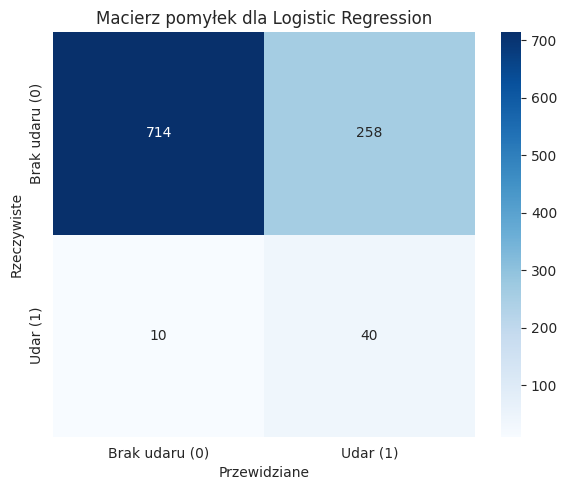

Model Logistic Regression zapisany w: models/logistic_regression_model.joblib

--- Trenowanie: Random Forest ---

--- Ocena dla modelu: Random Forest ---
Accuracy: 0.9364
F1 Score: 0.1096
Recall: 0.0800
Precision: 0.1739
AUC-ROC: 0.7693

Macierz pomyłek:
[[953  19]
 [ 46   4]]

Raport klasyfikacyjny:
                precision    recall  f1-score   support

Brak udaru (0)       0.95      0.98      0.97       972
      Udar (1)       0.17      0.08      0.11        50

      accuracy                           0.94      1022
     macro avg       0.56      0.53      0.54      1022
  weighted avg       0.92      0.94      0.93      1022

Ważność cech dla modelu: Random Forest
age: 0.3295
bmi: 0.1263
avg_glucose_level: 0.1247
ever_married_Yes: 0.0792
Residence_type_Urban: 0.0653
gender_Male: 0.0461
work_type_Private: 0.0410
smoking_status_formerly smoked: 0.0366
smoking_status_never smoked: 0.0347
work_type_Self-employed: 0.0344
hypertension: 0.0266
smoking_status_smokes: 0.0223
work_type_ch

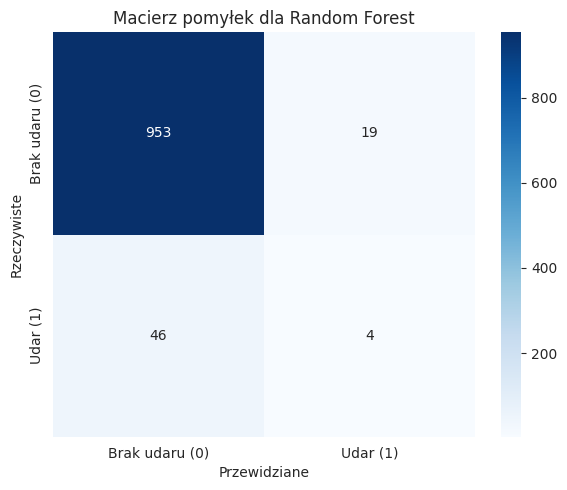

Model Random Forest zapisany w: models/random_forest_model.joblib

--- Trenowanie: Support Vector Machine ---

--- Ocena dla modelu: Support Vector Machine ---
Accuracy: 0.7534
F1 Score: 0.1923
Recall: 0.6000
Precision: 0.1145
AUC-ROC: 0.7791

Macierz pomyłek:
[[740 232]
 [ 20  30]]

Raport klasyfikacyjny:
                precision    recall  f1-score   support

Brak udaru (0)       0.97      0.76      0.85       972
      Udar (1)       0.11      0.60      0.19        50

      accuracy                           0.75      1022
     macro avg       0.54      0.68      0.52      1022
  weighted avg       0.93      0.75      0.82      1022


All arrays must be of the same length
(Wagi pominięte).


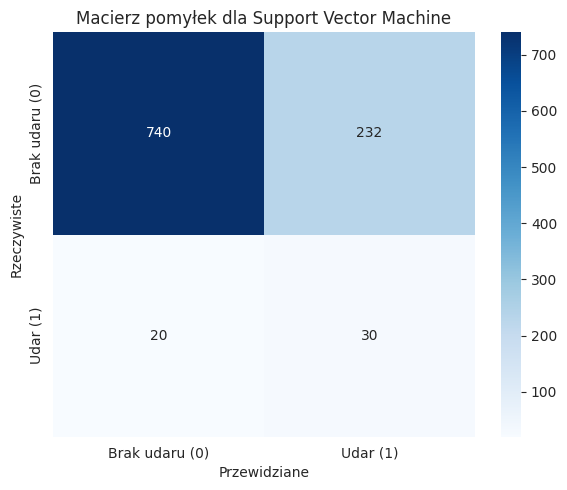

Model Support Vector Machine zapisany w: models/svm_model.joblib

--- Trenowanie: Voting Classifier ---

--- Ocena dla modelu: Voting Classifier ---
Accuracy: 0.8493
F1 Score: 0.2736
Recall: 0.5800
Precision: 0.1790
AUC-ROC: 0.8090

Macierz pomyłek:
[[839 133]
 [ 21  29]]

Raport klasyfikacyjny:
                precision    recall  f1-score   support

Brak udaru (0)       0.98      0.86      0.92       972
      Udar (1)       0.18      0.58      0.27        50

      accuracy                           0.85      1022
     macro avg       0.58      0.72      0.59      1022
  weighted avg       0.94      0.85      0.88      1022



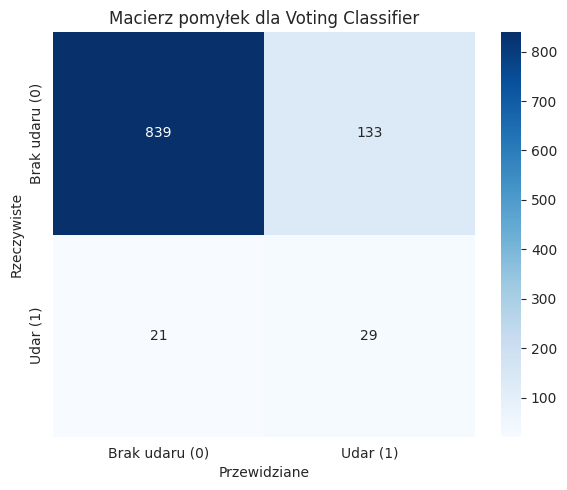

Model Voting Classifier zapisany w: models/voting_classifier_model.joblib


In [18]:
if not raw_df.empty:
    print("\n--- Trenowanie i Ewaluacja Modeli --- ")
    base_models_dict = define_base_models()
    trained_models = {}
    evaluation_results = {}

    model_filenames = {
        "Logistic Regression": LOG_REG_MODEL_NAME,
        "Random Forest": RF_MODEL_NAME,
        "Support Vector Machine": SVM_MODEL_NAME
    }

    # Trenowanie modeli bazowych
    for model_name, model_instance in base_models_dict.items():
        print(f"\n--- Trenowanie: {model_name} ---")
        model_pipeline = create_full_model_pipeline(
            preprocessor_obj, model_instance, use_smote=True)
        trained_pipeline = train_model(
            model_pipeline, X_train_df, y_train_series)
        trained_models[model_name] = trained_pipeline


        # Ewaluacja
        y_pred_test, y_proba_test = get_predictions(
            trained_pipeline, X_test_df)
        metrics, cm = print_evaluation_summary(
            model_name, y_test_series, y_pred_test, y_proba_test)
        evaluation_results[model_name] = metrics
        report_model(model_name, trained_pipeline, X_test_df, y_test_series)

        # Wizualizacja
        plot_confusion_matrix_heatmap(cm, model_name, save_plot=True)

        # Zapis modelu
        model_path = os.path.join(MODEL_SAVE_DIR, model_filenames[model_name])
        joblib.dump(trained_pipeline, model_path)
        print(f"Model {model_name} zapisany w: {model_path}")

    # Trenowanie Voting Classifier
    print("\n--- Trenowanie: Voting Classifier ---")
    vc_pipeline = define_voting_classifier_pipeline(
        preprocessor_obj,
        base_models_dict["Logistic Regression"],
        base_models_dict["Random Forest"],
        base_models_dict["Support Vector Machine"],
        use_smote=True
    )
    trained_vc_pipeline = train_model(vc_pipeline, X_train_df, y_train_series)
    trained_models["Voting Classifier"] = trained_vc_pipeline

    # Ewaluacja Voting Classifier
    y_pred_vc_test, y_proba_vc_test = get_predictions(
        trained_vc_pipeline, X_test_df)
    metrics_vc, cm_vc = print_evaluation_summary(
        "Voting Classifier", y_test_series, y_pred_vc_test, y_proba_vc_test)
    evaluation_results["Voting Classifier"] = metrics_vc
    plot_confusion_matrix_heatmap(cm_vc, "Voting Classifier", save_plot=True)

    # Zapis Voting Classifier
    model_path_vc = os.path.join(MODEL_SAVE_DIR, VOTING_MODEL_NAME)
    joblib.dump(trained_vc_pipeline, model_path_vc)
    print(f"Model Voting Classifier zapisany w: {model_path_vc}")

else:
    print("DataFrame jest pusty, pomijanie Trenowania i Ewaluacji.")

## 7. Porównanie Wyników i Wybór Modelu

Zbierzmy wyniki wszystkich modeli i porównajmy je, aby wybrać najlepszy.

In [19]:
if not raw_df.empty:
    print("\n--- Porównanie Wyników Ewaluacji Modeli ---")
    results_summary_df = pd.DataFrame(evaluation_results).T.sort_values(by="Recall", ascending=False)
    print(results_summary_df)
    results_summary_df.to_csv(os.path.join(RESULTS_DIR, "model_evaluation_summary.csv"))
    print("\nPodsumowanie wyników zapisane do pliku CSV.")
    
    best_model_name = results_summary_df.index[0] 
    print(f"\n🏆 Najlepszy model (wg Recall): {best_model_name}")
else:
    print("Brak wyników do porównania.")


--- Porównanie Wyników Ewaluacji Modeli ---
                        Accuracy  F1 Score  Recall  Precision   AUC-ROC
Logistic Regression     0.737769  0.229885    0.80   0.134228  0.839012
Support Vector Machine  0.753425  0.192308    0.60   0.114504  0.779095
Voting Classifier       0.849315  0.273585    0.58   0.179012  0.808951
Random Forest           0.936399  0.109589    0.08   0.173913  0.769311

Podsumowanie wyników zapisane do pliku CSV.

🏆 Najlepszy model (wg Recall): Logistic Regression


## 8. Przykład Użycia Najlepszego Modelu

Na koniec, pokażmy, jak można użyć najlepszego wytrenowanego modelu do przewidywania ryzyka udaru dla nowego, przykładowego pacjenta.

In [20]:
if not raw_df.empty:
    best_model_filename_map = {
        "Logistic Regression": LOG_REG_MODEL_NAME,
        "Random Forest": RF_MODEL_NAME,
        "Support Vector Machine": SVM_MODEL_NAME,
        "Voting Classifier": VOTING_MODEL_NAME
    }
    best_model_path = os.path.join(
        MODEL_SAVE_DIR, best_model_filename_map[best_model_name])

    try:
        loaded_best_model = joblib.load(best_model_path)
        print(f"\nPomyślnie załadowano najlepszy model: {best_model_path}")

        sample_patient_data = pd.DataFrame({
            'gender': ['Male', 'Female', 'Male', 'Female', 'Male'],
            'age': [48.0, 21.0, 68.0, 78.0, 32.0],
            'hypertension': [0, 0, 1, 0, 0],
            'heart_disease': [0, 0, 0, 1, 0],
            'ever_married': ['Yes', 'No', 'Yes', 'Yes', 'No'],
            'work_type': ['Private', 'Never_worked', 'Self-employed', 'Govt_job', 'Private'],
            'Residence_type': ['Rural', 'Urban', 'Urban', 'Rural', 'Urban'],
            'avg_glucose_level': [91.34, 85.10, 188.40, 102.57, 112.88],
            'bmi': [27.5, 22.1, 34.1, 29.8, 31.2],
            'smoking_status': ['never smoked', 'never smoked', 'formerly smoked', 'never smoked', 'smokes']
        }, columns=X_train_df.columns)


        pred_classes = loaded_best_model.predict(sample_patient_data)
        pred_probas = loaded_best_model.predict_proba(sample_patient_data)

        print("\n--- Predykcje dla nowych pacjentów ---")

        for i, (index, patient) in enumerate(sample_patient_data.iterrows()):
            predicted_class = pred_classes[i]
            stroke_probability = pred_probas[i][1]

            print(f"\n-> Pacjent {index}: Wiek {patient['age']}, Płeć {patient['gender']}")
            
            print(f"  Przewidziana klasa: {'Udar' if predicted_class == 1 else 'Brak udaru'} ({predicted_class})")
            print(f"  Prawdopodobieństwo udaru: {stroke_probability:.2%}")

    except FileNotFoundError:
        print(
            f"Błąd: Nie znaleziono zapisanego najlepszego modelu: {best_model_path}")
    except Exception as e:
        print(
            f"Wystąpił błąd podczas ładowania lub używania najlepszego modelu: {e}")
else:
    print("Nie można uruchomić przykładu - brak danych.")


Pomyślnie załadowano najlepszy model: models/logistic_regression_model.joblib

--- Predykcje dla nowych pacjentów ---

-> Pacjent 0: Wiek 48.0, Płeć Male
  Przewidziana klasa: Brak udaru (0)
  Prawdopodobieństwo udaru: 18.99%

-> Pacjent 1: Wiek 21.0, Płeć Female
  Przewidziana klasa: Brak udaru (0)
  Prawdopodobieństwo udaru: 2.05%

-> Pacjent 2: Wiek 68.0, Płeć Male
  Przewidziana klasa: Udar (1)
  Prawdopodobieństwo udaru: 82.64%

-> Pacjent 3: Wiek 78.0, Płeć Female
  Przewidziana klasa: Udar (1)
  Prawdopodobieństwo udaru: 81.22%

-> Pacjent 4: Wiek 32.0, Płeć Male
  Przewidziana klasa: Brak udaru (0)
  Prawdopodobieństwo udaru: 11.95%
